# generate P1 tests data
Construct photometric mock data using the `provabgs` pipeline

In [1]:
import os
import h5py
import numpy as np 
import scipy.stats 
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#if 'NERSC_HOST' not in os.environ.keys():
#    mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
import gqp_mc.fm as FM
import gqp_mc.util as UT

# read $\theta_{\rm obs}$, $\lambda_{\rm obs}$, $f_{\rm obs}$

In [3]:
theta_obs = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.theta.npy')
wave_full = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.wave_full.npy')
flux_full = np.load('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/provabgs_mocks/provabgs_mock.flux_full.npy')

In [4]:
z_obs = 0.2

# Construct photometry from the `provabgs` SED 

In [5]:
fluxes, mags = FM.Photo_DESI(wave_full, flux_full, bands=['g', 'r', 'z', 'w1', 'w2'])

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]


(0.0, 3)

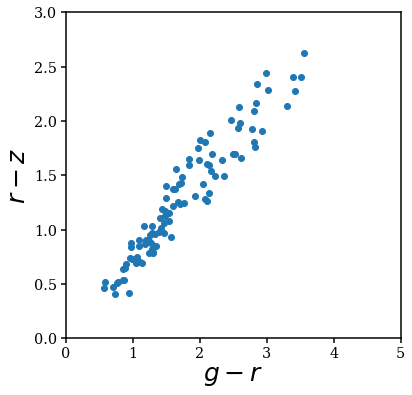

In [6]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(mags[:,0] - mags[:,1], mags[:,1] - mags[:,2], c='C0')
sub.set_xlabel('$g-r$', fontsize=25)
sub.set_xlim(0., 5)
sub.set_ylabel('$r-z$', fontsize=25)
sub.set_ylim(0., 3)

# assign DECaLS like noise to photometry
First lets read in a small subset of DECaLS photometry

In [7]:
bgs_targets = h5py.File(os.path.join(UT.dat_dir(), 'bgs.1400deg2.rlim21.0.hdf5'), 'r')

In [8]:
bgs_fluxes, bgs_mags, bgs_ivars = [], [], []
for b in ['g', 'r', 'z', 'w1', 'w2']: 
    bgs_fluxes.append(bgs_targets['flux_%s' % b][...])
    bgs_ivars.append(bgs_targets['flux_ivar_%s' % b][...])
    
    bgs_mags.append(22.5 - 2.5 * np.log10(bgs_targets['flux_%s' % b][...]))
    
bgs_fluxes = np.array(bgs_fluxes)
bgs_ivars = np.array(bgs_ivars)
bgs_mags = np.array(bgs_mags)

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


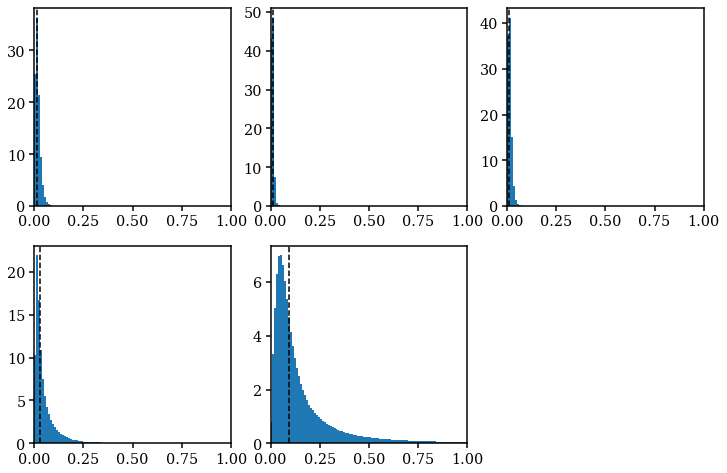

In [9]:
maxs = [1, 1, 1, 1, 1]
fig = plt.figure(figsize=(12, 8))
for i in range(5): 
    sub = fig.add_subplot(2,3,i+1)
    _ = sub.hist(bgs_ivars[i,:]**-0.5/bgs_fluxes[i,:], range=(0, maxs[i]), bins=100, density=True)
    sub.axvline(np.median(bgs_ivars[i,:]**-0.5/bgs_fluxes[i,:]), color='k', linestyle='--')
    sub.set_xlim(0, maxs[i])

In [10]:
median_frac_sig = np.median(bgs_ivars**-0.5/bgs_fluxes, axis=1)

In [11]:
flux_sig = fluxes * np.tile(median_frac_sig, (len(fluxes),1))

In [12]:
flux_ivars = flux_sig**-2

In [13]:
fluxes_obs = fluxes + flux_ivars**-0.5 * np.random.randn(fluxes.shape[0], fluxes.shape[1])

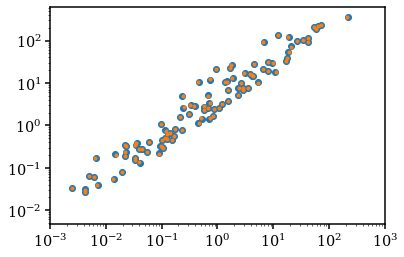

In [14]:
plt.scatter(fluxes[:,0], fluxes[:,1])
plt.errorbar(fluxes_obs[:,0], fluxes_obs[:,1], xerr=flux_sig[:,0], yerr=flux_sig[:,1], fmt='.C1')

plt.xlim(1e-3, 1e3)
plt.xscale('log')
plt.yscale('log')

# save to file

In [15]:
np.save('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/mocha_p1.flux.npy', fluxes_obs)
np.save('/global/cscratch1/sd/chahah/gqp_mc/mini_mocha/mocha_p1.ivar.npy', flux_ivars)